In [269]:
%load_ext autoreload
%autoreload 2
from targets.density_estimation_target import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


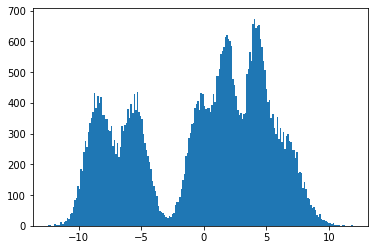

In [270]:
target = Dimension1()
data = target.sample(50000)
fig = plt.hist(data.numpy(), bins = 200)
plt.show()

In [296]:
from models import NDRE
structure = [20,20]

In [297]:
from prettytable import PrettyTable

def count_parameters(structure):
    model = NDRE(data, structure)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters(structure)
print(number_param)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
| logit_r.0.weight |     20     |
|  logit_r.0.bias  |     20     |
| logit_r.2.weight |    400     |
|  logit_r.2.bias  |     20     |
| logit_r.4.weight |     20     |
|  logit_r.4.bias  |     1      |
+------------------+------------+
Total Trainable Params: 481
481


In [298]:
N = 1
phi_0 = torch.randn(N,number_param)

In [299]:
def compute_log_p_phi_D(phi): 
    list_log_prob =[]
    for i in range(phi.shape[0]):
        phi_i = phi[i,:]
        model = NDRE(data, structure)
        for name, param in model.state_dict().items():
            num_element = param.numel()
            param_to_set, phi_i = phi_i[:num_element],phi_i[num_element:]
            param = param_to_set
        list_log_prob.append(torch.sum(model.log_density(data), dim= 0))
        
    return torch.stack(list_log_prob) + MultivariateNormal(torch.zeros(phi.shape[1]), torch.eye(phi.shape[1])).log_prob(phi)

compute_log_p_phi_D(phi_0)

tensor([-153561.2656], grad_fn=<AddBackward0>)

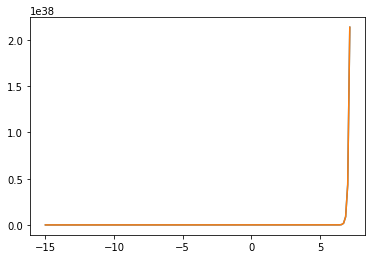

In [300]:
def from_phi_to_model(phi):
    model = NDRE(data, structure)
    current = 0
    for name, param in model.state_dict().items():
        num_element = param.numel()
        param_to_set = phi[current:current+num_element].reshape(param.shape)
        current += num_element
        param.copy_(param_to_set)
    return model

def from_model_to_phi(model):
    phi = list([])
    for name, param in model.state_dict().items():
        phi+=(list(param.flatten()))
    return torch.stack(phi, dim=-1)

model = from_phi_to_model(phi_0[0])
linspace = torch.linspace(-15.,15., 200)
plt.plot(linspace, torch.exp(model.log_density(linspace.unsqueeze(-1))).detach().numpy())
phi_0_prime = from_model_to_phi(model)
model_prime = from_phi_to_model(phi_0_prime)
linspace = torch.linspace(-15.,15., 200)
plt.plot(linspace, torch.exp(model_prime.log_density(linspace.unsqueeze(-1))).detach().numpy())

In [301]:
model_train = NDRE(data,structure)
model_train.train(epochs = 100)
phi_0 = from_model_to_phi(model_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s, loss = 1.311449]


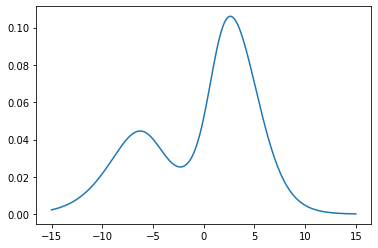

In [302]:
linspace = torch.linspace(-15.,15., 200)
plt.plot(linspace, torch.exp(model_train.log_density(linspace.unsqueeze(-1))).detach().numpy())

In [303]:
from posterior_sampler import MALA
mala_sampler = MALA(compute_log_p_phi_D, 2,number_param,x0 = phi_0.unsqueeze(0))
samples = mala_sampler.sample(100,0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.85it/s, acceptance = tensor(0.4900)]


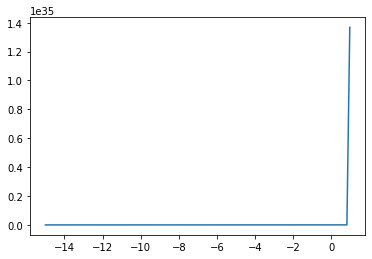

In [307]:
from IPython.display import clear_output
linspace = torch.linspace(-15.,15., 200)
sum_density = torch.zeros(200)
for i in range(3):
    clear_output(wait=True)
    plt.figure()
    model = from_phi_to_model(samples[i])
    sum_density = sum_density + torch.exp(model.log_density(linspace.unsqueeze(-1)))
    plt.plot(linspace, sum_density.detach().numpy())
    plt.show()